<a href="https://colab.research.google.com/github/VDai1999/Music_Before_During_Covid19/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Changes In the Taste of Music of Listeners Before and During Covid-19 (Top 200 Weekly Song's on Spotify Analysis)

The aim of this project is to determine the impact of the pandemic on the listeners' taste based on the weekly top 200 global song on Spotify. 
<br><br>
The songs and artists' names were retrieved from [Spotify website](https://spotifycharts.com/regional) during the period of 12/28/2018 to 12/04/2020. Based on the information of top songs, each song's features were collected using [Spotify API](https://spotipy.readthedocs.io/en/2.18.0/).

In [ ]:
# Import libraries
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials #To access authorised Spotify data
import csv
import pandas as pd
import glob
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

In [ ]:
# Connect to folders in Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Id retrieved from Spotify
client_id = ""
client_secret = ""

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

### **DATA CLEANING**

After downloading weekly top 200 songs from Spotify Website, all csvs files were uploaded to two separated folders in Google Drive. The first folder contains csv files from 12/28/2018 to 03/13/2020 exclusively (COVID-19 was declared as a pandemic on March 11, 2020), and the second folder contains files from 03/13/2020 to 12/04/2020 exclusively.

In [3]:
# A function that help read all csv files from a folder and return a dataframe without duplicated values
def read_csvs(path):
  all_files = glob.glob(path + "/*.csv")

  # Initialize a dataframe containing two columns: Track Name and Artist
  combined_df = pd.DataFrame(columns=['Track Name','Artist'])

  # Loop through all csv files and delete duplicated records using outer join
  for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=1)
    df.drop(["Position", "Streams", "URL"], axis = 1, inplace = True) 
    combined_df = pd.merge(combined_df, df, on=['Track Name','Artist'], how='outer')

  return combined_df

In [ ]:
# before_Covid data set: A data set that contains top songs being listened 
# before the pandemic (from 12/28/2018 to 03/13/2020 exclusively)
before_Covid = read_csvs(r'.../data_beforeCovid')
before_Covid.head()

In [ ]:
# during_Covid: A data set that contains top songs being listened 
# during the pandemic (from 03/13/2020 to 12/04/2020 exclusively)
during_Covid = read_csvs(r'.../data_duringCovid')
during_Covid.head()

In [6]:
# A function that condenses the song's name
def cleaning(df):
  # EX: Who (feat. BTS) => Who
  df['Track Name'] = df['Track Name'].str.replace(r"\(.*\)","")

  # Delete any words after hyphen ("-")
  for row in range (len(df)):
    df.iloc[row,0] = df.iloc[row,0].split(" -", 1)[0]

  return df

In [ ]:
# Cleaning song's names of the before_Covid data set
before_Covid = cleaning(before_Covid)
before_Covid.head()

In [ ]:
# Cleaning song's names of the during_Covid data set
during_Covid = cleaning(during_Covid)
during_Covid.head()

Songs appeared in both before_Covid and during_Covid dataset were deleted.

In [9]:
# A function that performs left outer join exclusive to delete shared songs in two datasets.
def left_outer_excl(df1, df2):
  # Delete shared songs between 2 datasets
  df_excl = pd.merge(df1, df2[['Track Name']], on='Track Name', how="left", 
                   indicator=True).query('_merge=="left_only"')

  # Drop the _merge column
  df_excl = df_excl.drop(columns=["_merge"])

  # Reset the index
  df_excl.reset_index(inplace=True, drop=True)

  return df_excl

In [ ]:
# Delete shared songs in the before_Covid data set
before_Covid_excl = left_outer_excl(before_Covid, during_Covid)
before_Covid_excl.head()

# Check the length of the new data set
len(before_Covid_excl)

In [ ]:
# Delete shared songs in the during_Covid data set
during_Covid_excl = left_outer_excl(during_Covid, before_Covid)
during_Covid_excl.head()

# Check the length of the new data set
len(during_Covid_excl)

In [ ]:
# Try to perform inner join between two new data sets to check if there are any shared songs left. 
# If the left outer join exclusive was done correctly, the returned dataframe should have 0 row.
pd.merge(before_Covid_excl, during_Covid_excl[["Track Name"]], on='Track Name')

In [ ]:
# Save the original dataframes into the csv files
before_Covid.to_csv(r'.../before_Covid.csv', index=False)
during_Covid.to_csv(r'.../during_Covid.csv', index=False)

In [ ]:
# Save the exclusive dataframes into the csv files
before_Covid_excl.to_csv(r'.../before_Covid_excl.csv', index=False)
during_Covid_excl.to_csv(r'.../during_Covid_excl.csv', index=False)

In [15]:
# Read before_Covid_excl.csv and during_Covid_excl.csv files
before_Covid_excl = pd.read_csv(".../before_Covid_excl.csv")
during_Covid_excl = pd.read_csv(".../during_Covid_excl.csv")

### **FEATURES RETRIEVAL FROM SPOTIFY**

After cleaning songs and artists' names, songs' features were retrieved from Spotify.

In [16]:
# A function that gets songs' features from JSON data format
def song_features(result):
    songFeature = {}
    track = result['tracks']['items'][0]['uri']
    features = sp.audio_features(track)
    cols = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 
            'liveness', 'valence', 'tempo', 'type', 'duration_ms']
    
    songFeature['artist'] = result['tracks']['items'][0]['artists'][0]['name']
    songFeature['song'] = result['tracks']['items'][0]['name']
    
    for col in cols:
        songFeature[col] = features[0][col]
        
    pop = sp.track(track)
    songFeature['popularity'] = pop['popularity']
    
    return songFeature

In [17]:
# A function that retrieves the features of the top song from Spotify
def get_Features(df):
    listSongFeature = []
    songFeatures_df = pd.DataFrame(columns= ['artist', 'song', 'danceability', 'energy', 'speechiness', 'acousticness', 
                                     'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'duration_ms', 
                                     'popularity'])
    
    for i in range (len(df)):
        artist = df['Artist'][i]
        song = df['Track Name'][i]

        result = sp.search(q=song + " " + artist, limit=1)
  
        sf = song_features(result)
        temp_df = pd.DataFrame(sf, index=[0])
        songFeatures_df = songFeatures_df.append(temp_df, ignore_index = True)
      
    return songFeatures_df
     

In [ ]:
########################
## BEFORE_COVID_EXCL
########################

# Delete "Lost in Japan" by Shawn Mendes and "Walk Me Home" by P!nk because of the difference in the format
before_Covid_excl.drop(before_Covid_excl.index[[520,657]], axis=0, inplace=True)

# Reset the index
before_Covid_excl.reset_index(inplace=True, drop=True)

# Get the features
before_Covid_Features = get_Features(before_Covid_excl)
before_Covid_Features_excl.head()

In [ ]:
########################
## DURING_COVID_EXCL
########################

# Delete "In meinem Benz" by AK AUSSERKONTROLLE because of the difference in the format
during_Covid_excl.drop(during_Covid_excl.index[[464]], axis=0, inplace=True)

# Reset the index
during_Covid_excl.reset_index(inplace=True, drop=True)

# Get the features
during_Covid_Features = get_Features(during_Covid_excl)
during_Covid_Features.head()

In [ ]:
# Save the features dataframes into the csv files
before_Covid_Features.to_csv(r'.../before_Covid_Features.csv', index=False)
during_Covid_Features.to_csv(r'.../during_Covid_Features.csv', index=False)

In [21]:
# Read before_Covid_Features.csv and during_Covid_Features.csv files
before_Covid_Features = pd.read_csv(".../before_Covid_Features.csv")
during_Covid_Features = pd.read_csv(".../during_Covid_Features.csv")

### **EXPLORATORY DATA ANALYSIS**

In [22]:
# Briefly explore the songs' features of before Covid data set
before_Covid_Features.info()
before_Covid_Features.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            1018 non-null   object 
 1   song              1018 non-null   object 
 2   danceability      1018 non-null   float64
 3   energy            1018 non-null   float64
 4   speechiness       1018 non-null   float64
 5   acousticness      1018 non-null   float64
 6   instrumentalness  1018 non-null   float64
 7   liveness          1018 non-null   float64
 8   valence           1018 non-null   float64
 9   tempo             1018 non-null   float64
 10  type              1018 non-null   object 
 11  duration_ms       1018 non-null   int64  
 12  popularity        1018 non-null   int64  
dtypes: float64(8), int64(2), object(3)
memory usage: 103.5+ KB


,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity
count,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,0.696663,0.637017,0.136681,0.242684,0.011727,0.179174,0.503140,122.037847,201116.891945,64.969548
std,0.142189,0.164937,0.116846,0.238973,0.070369,0.139128,0.213766,30.909769,46015.981559,14.140469
min,0.153000,0.054000,0.024700,0.000055,0.000000,0.019700,0.036000,46.718000,46837.000000,0.000000
25%,0.614750,0.544250,0.047900,0.054875,0.000000,0.099225,0.341000,96.991250,173031.000000,60.250000
50%,0.719000,0.654500,0.087250,0.162500,0.000000,0.124000,0.512000,119.960000,195967.500000,68.000000
75%,0.796000,0.756000,0.198500,0.361000,0.000021,0.210000,0.664000,144.091000,221424.750000,73.000000
max,0.974000,0.972000,0.856000,0.994000,0.918000,0.913000,0.977000,207.476000,577199.000000,88.000000


In [23]:
# Briefly explore the songs' features of during Covid data set
during_Covid_Features.info()
during_Covid_Features.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            579 non-null    object 
 1   song              579 non-null    object 
 2   danceability      579 non-null    float64
 3   energy            579 non-null    float64
 4   speechiness       579 non-null    float64
 5   acousticness      579 non-null    float64
 6   instrumentalness  579 non-null    float64
 7   liveness          579 non-null    float64
 8   valence           579 non-null    float64
 9   tempo             579 non-null    float64
 10  type              579 non-null    object 
 11  duration_ms       579 non-null    int64  
 12  popularity        579 non-null    int64  
dtypes: float64(8), int64(2), object(3)
memory usage: 58.9+ KB


,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity
count,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000
mean,0.707154,0.643221,0.134378,0.213386,0.016624,0.180109,0.498450,123.301665,194134.518135,71.799655
std,0.138840,0.143244,0.114204,0.225928,0.093882,0.139354,0.223718,29.783651,45169.941413,12.080809
min,0.184000,0.181000,0.025300,0.000192,0.000000,0.031100,0.036300,62.948000,30583.000000,0.000000
25%,0.635500,0.545000,0.050950,0.041050,0.000000,0.098150,0.332000,99.009500,167818.500000,66.000000
50%,0.728000,0.649000,0.087800,0.143000,0.000000,0.123000,0.495000,122.012000,190534.000000,73.000000
75%,0.810500,0.744500,0.191500,0.305000,0.000047,0.209000,0.661500,144.013000,213682.500000,79.000000
max,0.962000,0.970000,0.884000,0.991000,0.965000,0.944000,0.968000,203.903000,484147.000000,94.000000


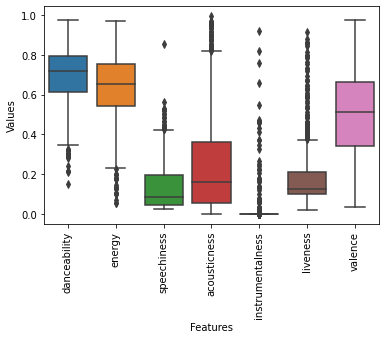

In [24]:
# Plot boxplot of before_Covid_Features dataframe
sns.boxplot(data=before_Covid_Features.drop(['artist', 'song', 'type', 'duration_ms', 'popularity', 'tempo'], axis=1))
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation='vertical')
plt.show()

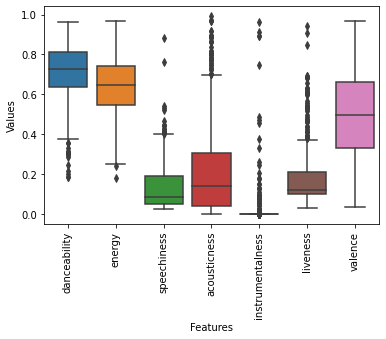

In [25]:
# Plot boxplot of during_Covid_Features dataframe
sns.boxplot(data=during_Covid_Features.drop(['artist', 'song', 'type', 'duration_ms', 'popularity', 'tempo'], axis=1))
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation='vertical')
plt.show()

Based on two boxplots above, we see that the distribution of most features are similiar when comparing each feature in pair (before versus during COVID-19 period). However, we will perform the statistical tests to make a final conclusion.

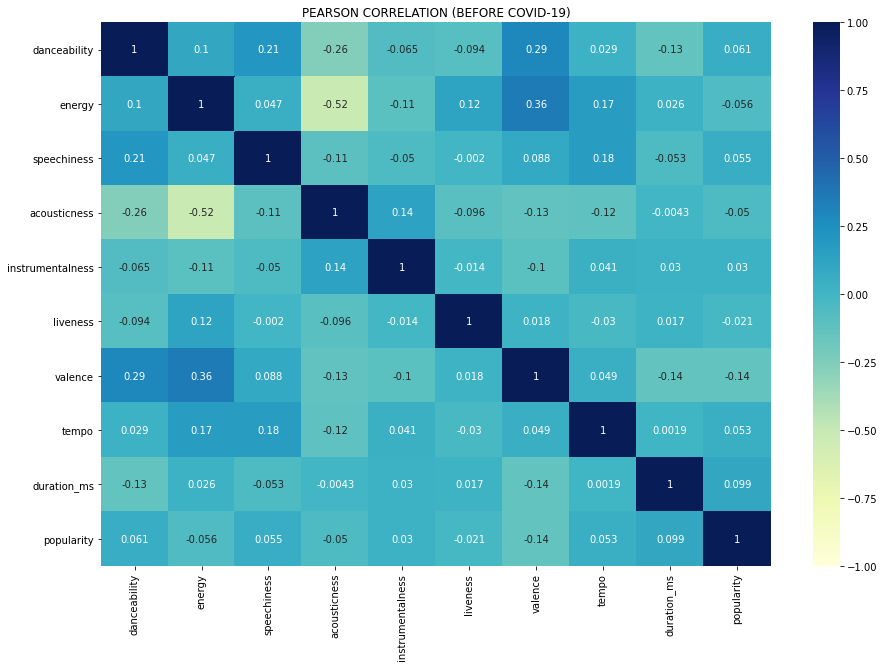

In [26]:
# Plot linear correlation matrix of before_Covid_Features dataframe
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(before_Covid_Features.corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
plt.title('PEARSON CORRELATION (BEFORE COVID-19)')
plt.show()

Based on the correlation matrix, it seems that the longer the song is, the less danceability, valence, and speechiness the song has. Furthermore, it seems that the popularity of a song positively correlates with the danceability, speechiness, instrumentalness, tempo, and duration of the song.

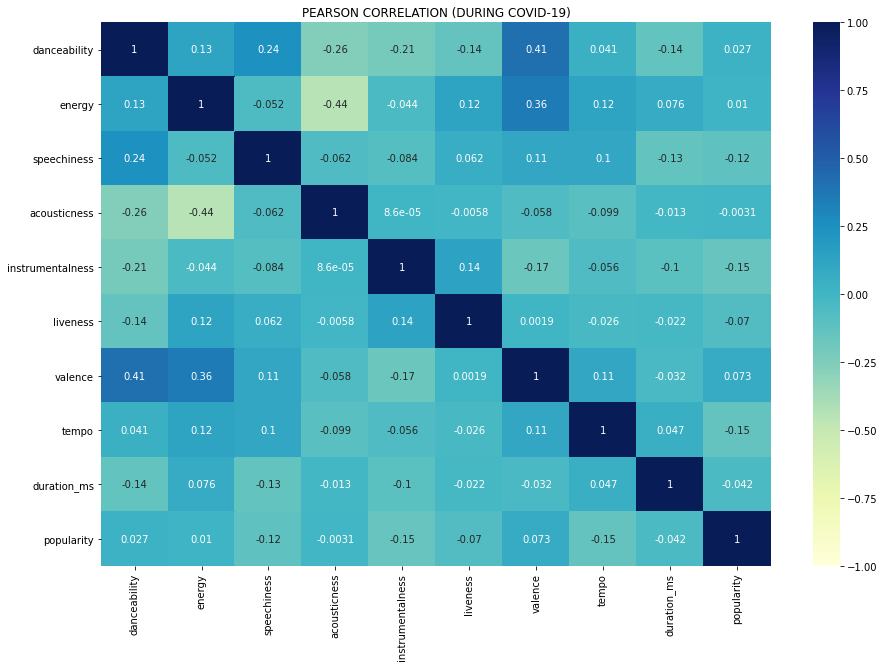

In [27]:
# Plot linear correlation matrix of during_Covid_Features dataframe
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(during_Covid_Features.corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
plt.title('PEARSON CORRELATION (DURING COVID-19)')
plt.show()

### **ANALYSIS**

In [28]:
# A function that takes 2 dataframes and the feature's name to conduct the two sample t-test in order to see
# if there is a significant difference in music's taste before and during the pandemic.
def two_sample_t(dat1, dat2, feature):
  arr1 = dat1.loc[:, feature].values.tolist()
  arr2 = dat2.loc[:, feature].values.tolist()
  stat, p = stats.ttest_ind(arr1, arr2)
  alpha = 0.05

  if p > alpha:
    print("Fail to reject H0. Therefore, two samples have the same distributions.")
  else:
    print("Reject H0. Therefore, two samples have difference distributions.")

  return "Result: Statistic=" + str(stat) + ", p-value=" + str(p)

In [29]:
# Source: https://github.com/bhattbhavesh91/GA_Sessions/blob/master/t_test_independence/T_Test_Sales.ipynb
# A function that draw histograms of 2 samples
def dist_plot(dat1, dat2, feature):
  arr1 = np.array(dat1.loc[:, feature])
  arr2 = np.array(dat2.loc[:, feature])

  plt.figure()
  ax1 = sns.distplot(arr1)
  ax2 = sns.distplot(arr2)
  plt.axvline(np.mean(arr1), color='blue', linestyle='dashed', linewidth=3)
  plt.axvline(np.mean(arr2), color='orange', linestyle='dashed', linewidth=3)

  return plt.figure

#### *Danceability*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure>

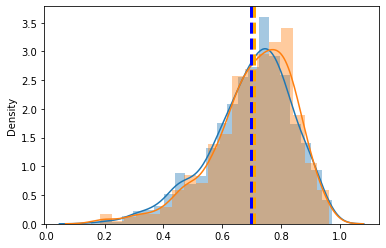

In [30]:
dist_plot(before_Covid_Features, during_Covid_Features, 'danceability')

In [31]:
two_sample_t(before_Covid_Features, during_Covid_Features, 'danceability')

Fail to reject H0. Therefore, two samples have the same distributions.


'Result: Statistic=-1.4295218385663884, p-value=0.15305013205491483'

#### *Energy*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure>

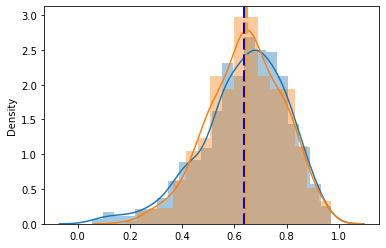

In [32]:
dist_plot(before_Covid_Features, during_Covid_Features, 'energy')

In [33]:
two_sample_t(before_Covid_Features, during_Covid_Features, 'energy')

Fail to reject H0. Therefore, two samples have the same distributions.


'Result: Statistic=-0.757147896450238, p-value=0.44907309333081513'

#### *Speechiness*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure>

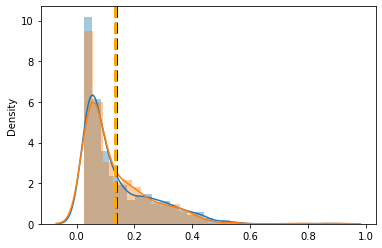

In [34]:
dist_plot(before_Covid_Features, during_Covid_Features, 'speechiness')

In [35]:
two_sample_t(before_Covid_Features, during_Covid_Features, 'speechiness')

Fail to reject H0. Therefore, two samples have the same distributions.


'Result: Statistic=0.3817534830223838, p-value=0.7026950766618072'

#### *Acousticness*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure>

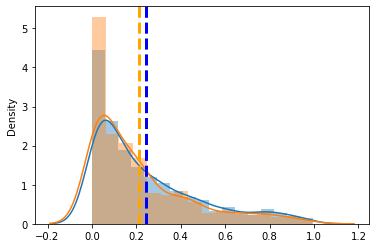

In [36]:
dist_plot(before_Covid_Features, during_Covid_Features, 'acousticness')

In [37]:
two_sample_t(before_Covid_Features, during_Covid_Features, 'acousticness')

Reject H0. Therefore, two samples have difference distributions.


'Result: Statistic=2.4019795647408992, p-value=0.016420364788646488'

#### *Instrumentalness*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure>

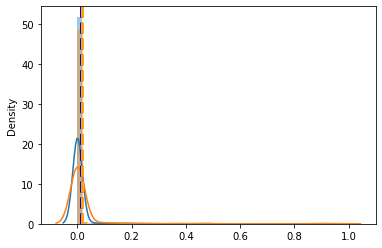

In [38]:
dist_plot(before_Covid_Features, during_Covid_Features, 'instrumentalness')

In [39]:
two_sample_t(before_Covid_Features, during_Covid_Features, 'instrumentalness')

Fail to reject H0. Therefore, two samples have the same distributions.


'Result: Statistic=-1.1804261862146328, p-value=0.2380067579463245'

#### *Liveness*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure>

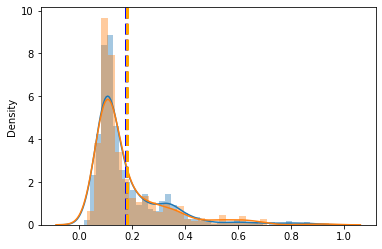

In [40]:
dist_plot(before_Covid_Features, during_Covid_Features, 'liveness')

In [41]:
two_sample_t(before_Covid_Features, during_Covid_Features, 'liveness')

Fail to reject H0. Therefore, two samples have the same distributions.


'Result: Statistic=-0.12901849392023781, p-value=0.8973592815206348'

#### *Valence*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure>

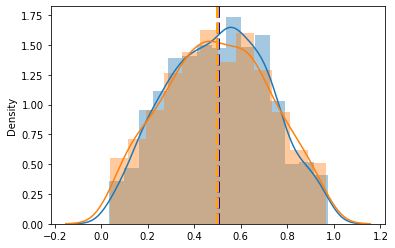

In [42]:
dist_plot(before_Covid_Features, during_Covid_Features, 'valence')

In [43]:
two_sample_t(before_Covid_Features, during_Covid_Features, 'valence')

Fail to reject H0. Therefore, two samples have the same distributions.


'Result: Statistic=0.4143841413246342, p-value=0.6786485220788466'

#### *Tempo*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure>

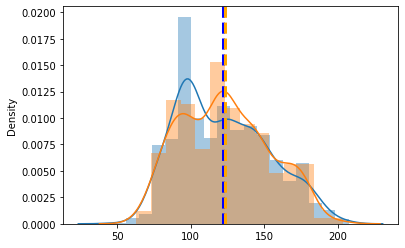

In [44]:
dist_plot(before_Covid_Features, during_Covid_Features, 'tempo')

In [45]:
two_sample_t(before_Covid_Features, during_Covid_Features, 'tempo')

Fail to reject H0. Therefore, two samples have the same distributions.


'Result: Statistic=-0.7958901351254092, p-value=0.42621432752057276'

It seems that the music's taste of Spotify listeners has not changed due to the pandemic.

### **SONG RECOMMENDATION**

In [46]:
full_features = before_Covid_Features.append(during_Covid_Features, ignore_index=True)
full_features.head()

,artist,song,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,popularity
0,Lil Uzi Vert,POP,0.741,0.599,0.419,0.00961,0.0,0.785,0.276,139.891,audio_features,227474,60
1,Lil Uzi Vert,Celebration Station,0.748,0.771,0.150,0.10100,0.0,0.135,0.792,142.086,audio_features,195058,63
2,Lil Uzi Vert,Bigger Than Life,0.776,0.752,0.193,0.32500,0.0,0.330,0.716,140.013,audio_features,192705,64
3,Lil Uzi Vert,Venetia,0.775,0.757,0.175,0.16200,0.0,0.148,0.562,142.933,audio_features,188800,65
4,Lil Uzi Vert,You Better Move,0.842,0.556,0.442,0.15900,0.0,0.204,0.306,118.836,audio_features,196639,61


In [47]:
full_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            1597 non-null   object 
 1   song              1597 non-null   object 
 2   danceability      1597 non-null   float64
 3   energy            1597 non-null   float64
 4   speechiness       1597 non-null   float64
 5   acousticness      1597 non-null   float64
 6   instrumentalness  1597 non-null   float64
 7   liveness          1597 non-null   float64
 8   valence           1597 non-null   float64
 9   tempo             1597 non-null   float64
 10  type              1597 non-null   object 
 11  duration_ms       1597 non-null   int64  
 12  popularity        1597 non-null   int64  
dtypes: float64(8), int64(2), object(3)
memory usage: 162.3+ KB


In [48]:
# Create a dataframe that only contains numeric columns
numeric_types = ['int64', 'float64']
numeric_features = full_features.select_dtypes(include=numeric_types)

# Normalize numeric columns
d = preprocessing.normalize(numeric_features, axis=0)
full_features_scaled = pd.DataFrame(d, columns=numeric_features.columns)
full_features_scaled.head()

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity
0,0.025951,0.022768,0.058731,0.000729,0.0,0.086492,0.012638,0.027731,0.027930,0.021808
1,0.026196,0.029305,0.021025,0.007659,0.0,0.014874,0.036265,0.028166,0.023950,0.022898
2,0.027177,0.028583,0.027053,0.024645,0.0,0.036360,0.032785,0.027755,0.023661,0.023262
3,0.027142,0.028773,0.024530,0.012285,0.0,0.016307,0.025733,0.028334,0.023182,0.023625
4,0.029488,0.021133,0.061955,0.012057,0.0,0.022477,0.014011,0.023557,0.024144,0.022171


In [49]:
# Extract a sub-dataframe that only contains non-numeric columns
nonnumeric_cols = full_features.select_dtypes(include=['object'])

# Merge non-numeric and normalized-numeric columns into one dataframe
full_df = nonnumeric_cols.join(full_features_scaled)

# Reorder columns
column_names = full_features.columns
full_df = full_df.reindex(columns=column_names)
full_df.head()

,artist,song,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,popularity
0,Lil Uzi Vert,POP,0.025951,0.022768,0.058731,0.000729,0.0,0.086492,0.012638,0.027731,audio_features,0.027930,0.021808
1,Lil Uzi Vert,Celebration Station,0.026196,0.029305,0.021025,0.007659,0.0,0.014874,0.036265,0.028166,audio_features,0.023950,0.022898
2,Lil Uzi Vert,Bigger Than Life,0.027177,0.028583,0.027053,0.024645,0.0,0.036360,0.032785,0.027755,audio_features,0.023661,0.023262
3,Lil Uzi Vert,Venetia,0.027142,0.028773,0.024530,0.012285,0.0,0.016307,0.025733,0.028334,audio_features,0.023182,0.023625
4,Lil Uzi Vert,You Better Move,0.029488,0.021133,0.061955,0.012057,0.0,0.022477,0.014011,0.023557,audio_features,0.024144,0.022171


It is possible that songs that do not share genres have similar characteristics. Therefore, a new column was created in order to distinguish songs from different groups. K-Means Clustering was used to create the new feature.

In [50]:
# Use 10 clusters
kmeans = KMeans(n_clusters=10, random_state=99)
group = kmeans.fit_predict(full_features_scaled)

# Normalize the predicted column
group = preprocessing.normalize([group])
group = pd.DataFrame(group)
group.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596
0,0.0,0.004564,0.041078,0.004564,0.022821,0.013693,0.031949,0.013693,0.031949,0.041078,0.022821,0.041078,0.013693,0.027385,0.022821,0.027385,0.013693,0.041078,0.013693,0.041078,0.022821,0.013693,0.004564,0.027385,0.013693,0.004564,0.004564,0.022821,0.027385,0.027385,0.022821,0.022821,0.004564,0.031949,0.004564,0.031949,0.004564,0.022821,0.027385,0.004564,...,0.027385,0.004564,0.041078,0.041078,0.027385,0.004564,0.027385,0.027385,0.013693,0.004564,0.022821,0.0,0.041078,0.036514,0.027385,0.027385,0.022821,0.041078,0.027385,0.013693,0.041078,0.041078,0.018257,0.018257,0.041078,0.004564,0.022821,0.022821,0.027385,0.022821,0.022821,0.0,0.031949,0.041078,0.027385,0.022821,0.004564,0.022821,0.013693,0.013693


In [51]:
# Change the dataframe from the wide to tall format
group = group.unstack().reset_index()
group.drop(group.columns[[0,1]], axis=1, inplace=True)

# Rename the column
group.columns = ['category']
group.head()

,category
0,0.000000
1,0.004564
2,0.041078
3,0.004564
4,0.022821


In [52]:
# Merge full_features_scaled and group dataframe together
full_df = pd.concat([full_df, group], axis=1)
full_df.head()

,artist,song,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,popularity,category
0,Lil Uzi Vert,POP,0.025951,0.022768,0.058731,0.000729,0.0,0.086492,0.012638,0.027731,audio_features,0.027930,0.021808,0.000000
1,Lil Uzi Vert,Celebration Station,0.026196,0.029305,0.021025,0.007659,0.0,0.014874,0.036265,0.028166,audio_features,0.023950,0.022898,0.004564
2,Lil Uzi Vert,Bigger Than Life,0.027177,0.028583,0.027053,0.024645,0.0,0.036360,0.032785,0.027755,audio_features,0.023661,0.023262,0.041078
3,Lil Uzi Vert,Venetia,0.027142,0.028773,0.024530,0.012285,0.0,0.016307,0.025733,0.028334,audio_features,0.023182,0.023625,0.004564
4,Lil Uzi Vert,You Better Move,0.029488,0.021133,0.061955,0.012057,0.0,0.022477,0.014011,0.023557,audio_features,0.024144,0.022171,0.022821


In [53]:
# A function that takes the song's name and the number of similar songs that listeners want to find
# to generate the final recommendation list
def recommendation(name, num=1):
  dist_arr = []

  # Retrieve selected song's information
  selected_song = full_df.loc[full_df.song.str.lower() == name, ]
  # Extract the numeric data of the selected song
  selected_song_num = selected_song.select_dtypes(include=numeric_types)

  # Drop the selection song information
  df = full_df[full_df.song.str.lower() != name]
  # Create a sub-dataframe of df that only includes numeric data
  df_numeric = df.select_dtypes(include=numeric_types)

  # Calculate the distance of numeric features between selected song and all other songs using Euclidean distance
  for i in range(len(df)):
    song = pd.DataFrame(df_numeric.iloc[0,:]).T
    # Calculate the distance
    dist = euclidean(selected_song_num, song)
    # Add the calculated distance to dist_arr list
    dist_arr.append(dist)

  # Merge the dist_arr list to the df dataframe
  df['distance'] = dist_arr

  # Sort the df dataframe by distance in ascending order
  df = df.sort_values('distance')
  
  # Return the artists and 
  return df[['artist', 'song']][:num].reset_index()

In [54]:
# Generate suggestion list of songs that are similar to ON by BTS
recommendation('on', 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,artist,song
0,0,Lil Uzi Vert,POP
1,1070,Megan Thee Stallion,Body
2,1069,Maluma,Hawái - Remix
3,1068,Justin Quiles,Jeans
4,1067,J Balvin,UN DIA (ONE DAY)
5,1066,Bad Bunny,TRELLAS
6,1065,Ritt Momney,Put Your Records On
7,1064,Bad Bunny,120
8,1063,Drake,Laugh Now Cry Later (feat. Lil Durk)
9,1062,Bad Bunny,SORRY PAPI
